# Generate initial designs for training data for ART

First import ART package:

In [1]:
import sys
sys.path.append('../AutomatedRecommendationTool')
    
from art.core import *

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


All genes we might consider in relation to isopentenol production:

In [2]:
reactions = ['ACCOAC', 
             'MDH',
             'PTAr', 
             'CS', 
             'ACACT1r', 
             'PPC', 
             'PPCK', # zero flux
             'PFL', # zero flux, can be forced
             'PYK', # zero flux 
             'POX'] # zero flux

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

Assing numerical categories to each of the modifications:

In [3]:
modif_dict = {'KO': int(0), 
              'NoMod': int(1),
              'UP': int(2)}

As current version of ART deals only with continuous variables, we will first find recommended designs from interval [0, 1] and then transform each of those to one of defined categories {0, 1, 2} using the function

$$f(x) = 3\lfloor x \rfloor$$

How many reactions you want to consider?

In [4]:
n_reactions = int(input())


 8


How many instances you want to generate?

In [5]:
n_instances = int(input())

 96


In [6]:
n_modifications = len(modif_dict)
reactions = reactions[:n_reactions]
tot_number_mod = n_modifications**n_reactions
print(f'Total number of possible modifications: {tot_number_mod}')
trainingset = n_instances/tot_number_mod*100
print(f'Training set size: {n_instances} ({trainingset:.2f}%)')

Total number of possible modifications: 6561
Training set size: 96 (1.46%)


Next define a dictionary that contains the settings that ART will use to find the recommended designs:

In [7]:
art_params = {}
art_params['input_var'] = reactions
art_params['num_recommendations'] = n_instances - 1
art_params['initial_cycle'] = True
art_params['seed'] = 10
art_params['output_directory'] = './art_files'


Generate recommendations by running ART:

In [8]:
art = RecommendationEngine(**art_params)
df = art.recommendations.copy()
df.tail()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
90,0.834820,0.310928,0.017741,0.686528,0.038425,0.702041,0.909326,0.314650
91,0.253443,0.144406,0.797025,0.866835,0.196778,0.915534,0.227534,0.997582
92,0.448214,0.982897,0.229292,0.020562,0.236674,0.920214,0.671678,0.159832
93,0.058396,0.672483,0.191037,0.602885,0.087692,0.708920,0.656125,0.545103
94,0.012306,0.396266,0.981174,0.236980,0.613428,0.391463,0.127033,0.926296


Transform the values for designs back to categories (0, 1 or 2):

In [9]:
df = np.floor(3 * df)
df.tail()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
90,2.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0
91,0.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0
92,1.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0
93,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0
94,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0


Define wild type strain with no modifications:

In [10]:
df.loc[n_instances-1] = [modif_dict['NoMod'] for i in range(n_reactions)] 
df = df.astype(int)
df.tail()

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,0,0,2,2,0,2,0,2
92,1,2,0,0,0,2,2,0
93,0,2,0,1,0,2,1,1
94,0,1,2,0,1,1,0,2
95,1,1,1,1,1,1,1,1


Create Line Names:

In [11]:
df.insert(loc=0, column='Line Name', value=[str(i) for i in range(1,n_instances)]+['WT'])
df.tail()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,92,0,0,2,2,0,2,0,2
92,93,1,2,0,0,0,2,2,0
93,94,0,2,0,1,0,2,1,1
94,95,0,1,2,0,1,1,0,2
95,WT,1,1,1,1,1,1,1,1


How many modifications 'introduced' into each strain?

In [12]:
def num_of_modifications(df):
    num_instances = len(df)
    values = np.empty(num_instances)
    for i in range(num_instances):
        design = df.loc[i][1:]
        values[i] = list(design).count(0) + list(design).count(2)
    return values
            

In [13]:
df['# Modifs'] = num_of_modifications(df)
df.tail()

,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,# Modifs
91,92,0,0,2,2,0,2,0,2,8.0
92,93,1,2,0,0,0,2,2,0,7.0
93,94,0,2,0,1,0,2,1,1,5.0
94,95,0,1,2,0,1,1,0,2,5.0
95,WT,1,1,1,1,1,1,1,1,0.0


Find distribution of modifications per gene in the training data set:

In [14]:
df.loc[n_instances] = ['Summary'] + [[list(df[reaction]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for reaction in reactions] + [np.mean(df['# Modifs'])]
df.iloc[-1]

Line Name                                              Summary
ACCOAC          [32.29166666666667, 34.375, 33.33333333333333]
MDH          [33.33333333333333, 33.33333333333333, 33.3333...
PTAr         [33.33333333333333, 33.33333333333333, 33.3333...
CS              [33.33333333333333, 34.375, 32.29166666666667]
ACACT1r      [32.29166666666667, 35.41666666666667, 32.2916...
PPC             [33.33333333333333, 34.375, 32.29166666666667]
PPCK            [32.29166666666667, 34.375, 33.33333333333333]
PFL          [33.33333333333333, 33.33333333333333, 33.3333...
# Modifs                                               5.27083
Name: 96, dtype: object

In [15]:
def plot_distribution(dataframe): 
    bar_height = 1
    labels = ['KO', 'NoMod', 'UP']
    colors = ['#019600', 'grey', '#219AD8']

    data = [ [dataframe[dataframe['Line Name']=='Summary'][r].values[0][num] for r in reactions] 
            for num in range(n_modifications)]
    y_pos = np.arange(len(reactions))

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)

    # Remove frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    patch_handles = []
    # left alignment of data starts at zero
    left = np.zeros(len(reactions)) 
    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y_pos, d, 
                                     color=colors[i%len(colors)], edgecolor='white',
                                     height=bar_height, align='center', 
                                     left=left, label=labels[i]))
        left += d

    # search all of the bar segments and annotate
    for j in range(n_modifications):
        for i, patch in enumerate(patch_handles[j].get_children()):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x,y, "%d%%" % (data[j][i]), ha='center')

    ax.set_title('Distribution of modifications')
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', 
                    labelbottom='off')
    plt.yticks(y_pos, reactions)
    ax.invert_yaxis()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


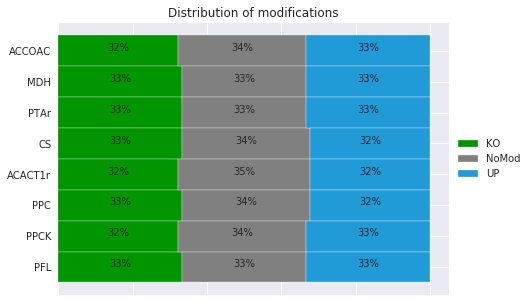

In [16]:
plot_distribution(df)

Save training set:

In [17]:
data_filename = f'./data/training_data_{n_reactions}reactions.csv'
df.loc[0:(n_instances-1)].to_csv(data_filename, 
                                 columns = ['Line Name'] + reactions, 
                                 header = True, index = False)